In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time

In [2]:
url = "https://raw.githubusercontent.com/doctor-phil/analyzing-economic-networks/main/stocks.csv"
df = pd.read_csv(url) # load a dataset of weekly returns for some popular stocks over the past year
#load yesterdays top 100 stocks
df.head(5) # take a peek at the data

,Date,AAPL,AMZN,BAC,C,FB,GOOG,MSFT,JPM,V,WFC
0,1/25/2021,0.036374,0.045521,-0.063456,0.047653,0.037820,0.142863,0.044145,0.022682,0.010891,0.113961
1,2/1/2021,-0.008685,-0.022207,0.052859,0.036858,0.008952,0.002912,0.011519,0.030858,0.037142,0.011411
2,2/8/2021,-0.040629,-0.008485,0.043816,0.035116,-0.033050,-0.001412,-0.016409,0.066417,0.031438,0.054223
3,2/15/2021,-0.066297,-0.048300,0.081788,0.058597,-0.015063,-0.030593,-0.033426,0.045614,0.039482,0.038190
4,2/22/2021,0.001319,-0.029897,0.096682,0.090000,0.025852,0.035191,-0.003357,0.093960,0.073817,0.120655


In [3]:
returns = df.drop(df.columns[0], axis=1)
returns.head()

,AAPL,AMZN,BAC,C,FB,GOOG,MSFT,JPM,V,WFC
0,0.036374,0.045521,-0.063456,0.047653,0.037820,0.142863,0.044145,0.022682,0.010891,0.113961
1,-0.008685,-0.022207,0.052859,0.036858,0.008952,0.002912,0.011519,0.030858,0.037142,0.011411
2,-0.040629,-0.008485,0.043816,0.035116,-0.033050,-0.001412,-0.016409,0.066417,0.031438,0.054223
3,-0.066297,-0.048300,0.081788,0.058597,-0.015063,-0.030593,-0.033426,0.045614,0.039482,0.038190
4,0.001319,-0.029897,0.096682,0.090000,0.025852,0.035191,-0.003357,0.093960,0.073817,0.120655


<Axes: >

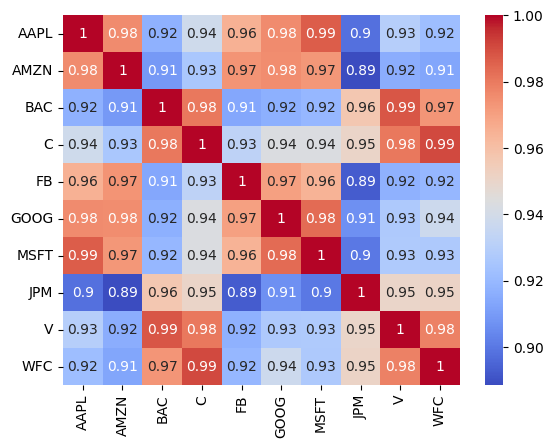

In [4]:
corr = returns.corr() # calculate the correlations between the returns of each pair of stocks
corr # display the correlation matrix
import seaborn as sns
sns.heatmap(corr,annot=True,cmap="coolwarm")

In [113]:
df = pd.DataFrame(corr)

# get the column names
titles = df.columns.tolist()


In [114]:
def truncate(f): # define a function that "rounds" a number to 0 if it is lower than 0.92, and to 1 if it is higher (or equal).
    if (abs(f) < 0.925):
        return 0.
    else:
        return 1
    
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
adj = corr.applymap(truncate) - np.identity(10)
adj

,AAPL,AMZN,BAC,C,FB,GOOG,MSFT,JPM,V,WFC
AAPL,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
AMZN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
BAC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
C,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
FB,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
GOOG,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
MSFT,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
JPM,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
V,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
WFC,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [115]:
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
istocknet=stocknet
istock_layout = nx.spring_layout(istocknet,seed=10)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
#nx.draw(stocknet,stock_layout) # plot the graph, without any labels (for now)

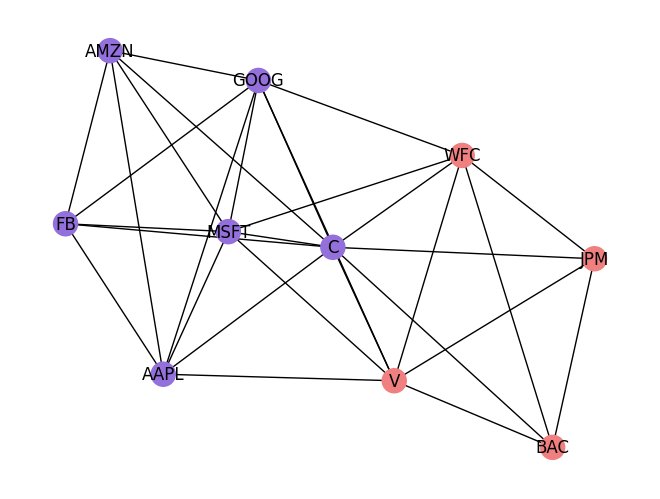

In [116]:
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,10) ]
for i in range(0,10):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"
        
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True)

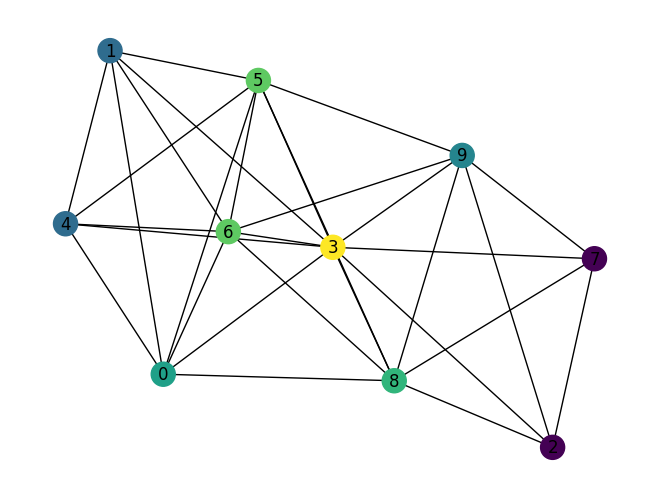

In [117]:
eigen_cent = nx.eigenvector_centrality(istocknet)
eigen_colors = [eigen_cent[i] for i in range(0,10)]
nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True)
#nx.draw(stocknet,stock_layout)

In [118]:
print(eigen_cent)

{0: 0.3258492845403566, 1: 0.27859995208513927, 2: 0.20099212635791755, 3: 0.4219404845562419, 4: 0.27859995208513927, 5: 0.3670153823393961, 6: 0.3670153823393961, 7: 0.20099212635791755, 8: 0.3458080088597427, 9: 0.30128586790378553}


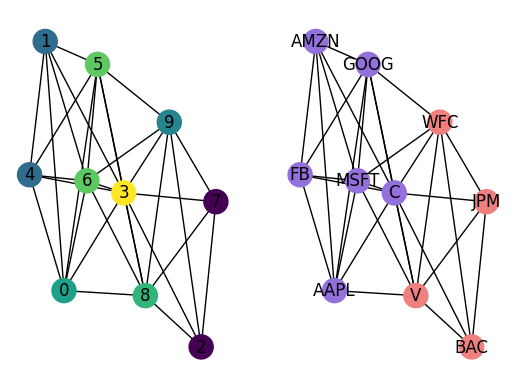

In [119]:
# Create two example graphs
G1 = nx.complete_graph(5)
G2 = nx.cycle_graph(6)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2)

# Draw the graphs in the subplots
nx.draw(istocknet,istock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()

In [120]:
#df = pd.DataFrame(eigen_cent)
print(eigen_cent)
#stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns)))

{0: 0.3258492845403566, 1: 0.27859995208513927, 2: 0.20099212635791755, 3: 0.4219404845562419, 4: 0.27859995208513927, 5: 0.3670153823393961, 6: 0.3670153823393961, 7: 0.20099212635791755, 8: 0.3458080088597427, 9: 0.30128586790378553}


In [121]:

df = pd.DataFrame(eigen_cent,index=[0])
dfT= pd.DataFrame(titles)
# print the resulting DataFrame
mat1=df.T
mat2=dfT

joined_mat = pd.concat([mat1, mat2], axis=1)
df=joined_mat
# print the resulting joined matrix
joined_mat.head()
df.columns = ['centrality', 'stock']
df = df.iloc[:, [1, 0]]
df = df.sort_values('centrality',ascending=False)
df=df.reset_index(drop=True)
centralitydf=df

print(centralitydf)

  stock  centrality
0     C    0.421940
1  GOOG    0.367015
2  MSFT    0.367015
3     V    0.345808
4  AAPL    0.325849
5   WFC    0.301286
6  AMZN    0.278600
7    FB    0.278600
8   BAC    0.200992
9   JPM    0.200992


In [122]:
decay=1
decay_coeff=1/2
def buy_algo (centralitydf,decay,decay_coeff):
    for x in range(0,10)
        buy.df[x]*decay
        decay=decay*decay_coeff
        
def decay_optimizer():
    df=[]
    for x in np.linspace(0, 1, 10)
        df=df.append(buy_algo(cetranlitydf,decay,decay_coeff=x))
        #make code that extracts decay_coeff
        optimal=max(df)
    return optimal,  

    

SyntaxError: expected ':' (2741352801.py, line 4)

In [51]:
from scipy.optimize import minimize_scalar

# Define the function to be optimized
def my_func(x):
    return x**2 - 4*x + 3

# Set the range over which to optimize the function
x_range = (-10, 10)

# Use the minimize_scalar function to find the minimum value of the function within the given range
result = minimize_scalar(my_func, bounds=x_range)

# Print the minimum value and the value of x at which it occurs
print("Minimum value:", result.fun)
print("Optimal x value:", result.x)

Minimum value: -1.0
Optimal x value: 2.0
